# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.837625,True,4.463464
1,1.970818,True,4.531151
2,2.369800,True,5.122748
3,1.516296,True,8.028153
4,1.509464,True,6.950984
...,...,...,...
995,0.603750,True,2.886611
996,0.706733,True,5.552090
997,-0.848687,True,3.856235
998,-0.305758,False,-0.144103


<AxesSubplot: xlabel='v0'>

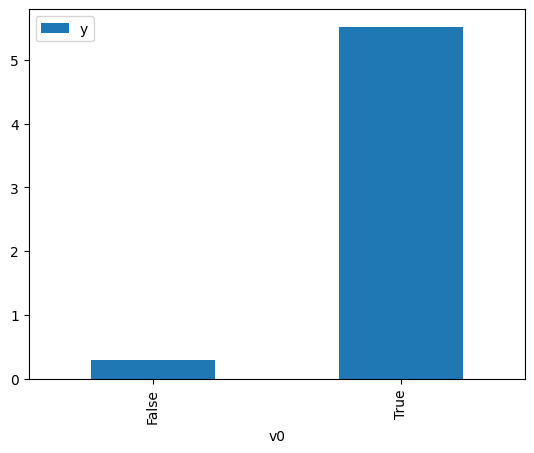

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

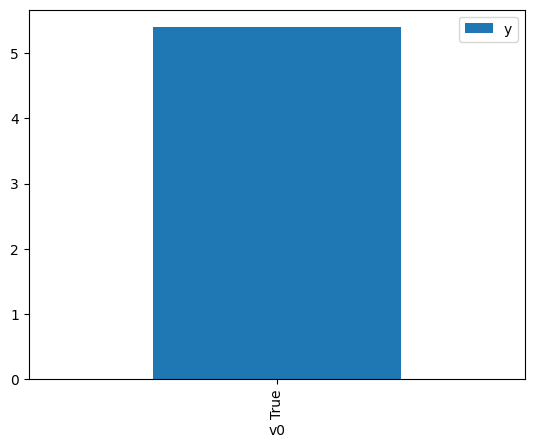

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.659040,False,0.908117,0.255960,3.906865
1,1.823928,False,1.528957,0.060376,16.562781
2,1.026635,False,1.401280,0.168467,5.935870
3,1.561227,False,-1.265168,0.085762,11.660127
4,0.977908,False,1.938071,0.178529,5.601335
...,...,...,...,...,...
995,1.042399,False,1.948735,0.165311,6.049219
996,-1.682238,False,-1.996657,0.909299,1.099748
997,-0.129092,False,0.603994,0.517014,1.934182
998,0.977908,False,1.938071,0.178529,5.601335


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.196647,True,5.599873,0.863114,1.158595
1,0.583576,True,5.601883,0.722798,1.383512
2,1.798500,True,4.547092,0.937512,1.066653
3,0.188380,True,5.653405,0.596084,1.677615
4,-0.600442,True,5.486427,0.321480,3.110609
...,...,...,...,...,...
995,-0.593921,True,5.125966,0.323532,3.090880
996,0.137799,True,4.172470,0.578428,1.728824
997,1.327460,True,4.473735,0.883892,1.131360
998,0.440047,True,3.777446,0.679539,1.471585


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.096e+04
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:31:50   Log-Likelihood:                         -1438.9
No. Observations:                1000   AIC:                                      2882.
Df Residuals:                     998   BIC:                                      2892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4161      0.036     11.590      0.000       0.346       0.487
x2             5.0342      0.058     87.335      0.000       4.921       5.147
==============================================================================
Omnibus:                        2.943   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.872
Skew:                          -0.091   Prob(JB):                        0.238
Kurtosis:                       3.190   Cond. No.                         3.10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""